# Post-processing raw wrfout netcdf files

Notebook outlining how to read, process, and write wrfout netCDF files to Zarr (using wrf-python)

In [1]:
import os
from glob import glob
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt

xr.set_options(display_style="html");

In [5]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} wrf-python netCDF4 salem

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::esmf==8.0.1=mpi_mpich_h3cbecb6_102
  - conda-forge/linux-64::esmpy==8.0.1=mpi_mpich_py38h6f0bf2d_102
  - conda-forge/noarch::xesmf==0.5.1=pyhd8ed1ab_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - netcdf4
    - salem
    - wrf-python


The following NEW packages will be INSTALLED:

  salem              conda-forge/noarch::salem-0.3.4-pyhd8ed1ab_0
  wrf-python         conda-forge/linux-64::wrf-python-1.3.2.5-py38h0e9072a_0

The following packages will be UPDATED:

  esmf                         8.0.1-mpi_mpich_h3cbecb6_102 --> 8.1.0-mpi_mpich_h224d73f_100
  esmpy                    8.0

In [6]:
import wrf
import salem
from netCDF4 import Dataset

In [ ]:
## A chunk of code to start dask cluster
from dask.distributed import Client, progress
from dask_gateway import Gateway
gateway = Gateway()

In [7]:
if gateway.list_clusters():
    cluster_name = gateway.list_clusters()[0].name
    cluster = gateway.connect(cluster_name)
    print(f"\nConnecting to pre-existing cluster with {len(cluster.scheduler_info['workers'])} workers.")
else:
    cluster = gateway.new_cluster() 
    cluster.adapt(minimum=4, maximum=12)
    print("\nStarting up and connecting to new cluster.")

cluster
# cluster.scheduler_info

NameError: name 'gateway' is not defined

In [ ]:
client = cluster.get_client()
client

## Read in RAW wrfout tiles

### setup runtime parameters

In [8]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'

# domain = 'domain_02'
# filepattern = 'wrfout_d02_20191231*'
# pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
# print(pattern)

domain = 'domain_03'
filepattern = 'wrfout_d03_20190930*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, filepattern)
print(pattern)

gs://ldeo-glaciology/AMPS/WRF_24/wrfout_d03_20190930*


### list the netcdf files

In [9]:
import gcsfs
from tqdm import tqdm
# from tqdm.autonotebook import tqdm
import fsspec

fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [10]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 8 wrf files.

ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093000_f003.nc


In [11]:
# NCs_urls = ['gs://ldeo-glaciology' + x for x in NCs]
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs] #  + '#mode=bytes' needed for open_mfdataset

print(NCs_urls)


['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093000_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093000_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093000_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093000_f012.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093012_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093012_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093012_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093012_f012.nc#mode=bytes']


## using `salem`

In [19]:
# wrflist = [Dataset(x) for x in NCs_urls]

# ds = salem.open_mf_wrf_dataset(wrflist, 
#                 chunks={'Time':-1})


## using `netCDF4.Dataset`

### get variables needed using wrf-python's `getvar`

single

In [15]:
# ncfile = Dataset(NCs_urls[0])
# # ncfile.variables.keys()

# # T_sfc = getvar(ncfile, "T_sfc")
# # Td = getvar(ncfile, "tk")
# da = wrf.getvar(ncfile, "ALBEDO", timeidx=wrf.ALL_TIMES)
# da

In [16]:
# plt.pcolor(wrf.to_np(da), cmap='Greys_r')
# plt.colorbar()

mutliple files

In [ ]:
# # Creating a simple test list with four timesteps
# wrflist = [Dataset(NCs_urls[0]),
#            Dataset(NCs_urls[1]),
#            Dataset(NCs_urls[2]),
#            Dataset(NCs_urls[3])]

wrflist = [Dataset(x) for x in NCs_urls]

In [ ]:
# plot_vars_list = ['HFX', 'LH', 'GFX', 'PBLH', 'ACSNOM', 'SWDOWN', 'LWDNB', 'TSK']
get_vars_list = ['cloudfrac', 'slp', 'T2', 'theta_e', 'times', 
                 'uvmet', 'uvmet_wspd_wdir',
                 'lat', 'lat', 
                 '', '', '', '']

da = wrf.getvar(wrflist, 
                'slp', #get_vars_list[1], 
                timeidx=wrf.ALL_TIMES, 
                method='cat') #, method="join", squeeze=False)

In [20]:
da = da.chunk(chunks={'Time':-1})
da

<xarray.DataArray 'times' (Time: 8)>
dask.array<xarray-<this-array>, shape=(8,), dtype=datetime64[ns], chunksize=(8,), chunktype=numpy.ndarray>
Dimensions without coordinates: Time
Attributes:
    description:  model times [np.datetime64]

In [21]:
%%time
da.mean().compute()

CPU times: user 28.8 ms, sys: 4.91 ms, total: 33.8 ms
Wall time: 65 ms


<xarray.DataArray 'times' ()>
array('2019-09-30T13:30:00.000000000', dtype='datetime64[ns]')

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([18169.0625, 18169.1625, 18169.2625, 18169.3625, 18169.4625,
        18169.5625, 18169.6625, 18169.7625, 18169.8625, 18169.9625,
        18170.0625]),
 <BarContainer object of 10 artists>)

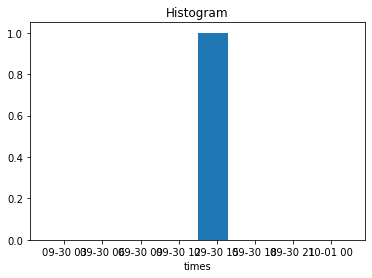

In [22]:
da.mean(dim='Time').plot()

In [40]:
ds = da.to_dataset()
ds

<xarray.Dataset>
Dimensions:   (Time: 8, south_north: 1035, west_east: 675)
Coordinates:
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(1035, 675), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(1035, 675), meta=np.ndarray>
    XTIME     (Time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
  * Time      (Time) datetime64[ns] 2019-09-30T03:00:00 ... 2019-10-01
    datetime  (Time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    T2        (Time, south_north, west_east) float32 dask.array<chunksize=(8, 1035, 675), meta=np.ndarray>

# Write to Zarr


In [ ]:
import gcsfs
from tqdm import tqdm
import fsspec

In [ ]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'domain_03'

outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-postproc/')

In [ ]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

# fs.glob(outdir)
fs.ls(outdir)

In [ ]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'test_20161225-T2_gcp.zarr', mode='ab',
                            token=token)


## Projections

### remove them altogether

but ideally give the PROJ4 string if appropriate

In [ ]:
# del ds.T2.attrs['projection']

ds.T2.attrs['projection'] = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

In [ ]:
# ds.to_zarr('data', mode='w');

ds.to_zarr(amps_mapper,
           mode='w',
           consolidated=True);

## test reading in that zarr file

In [ ]:
# gcsmap = gcsfs.mapping.GCSMap(outdir + 'test_20161225-T2.zarr', gcs=fs, check=True, create=False)

AMPS_gcs = xr.open_zarr(amps_mapper)

In [ ]:
AMPS_gcs

In [ ]:
plot_time = 1
plot_var = 'T2'

import shapely.geometry as sgeom
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    
box = sgeom.box(minx=160, maxx=200, miny=-88, maxy=-76)
# box = sgeom.box(minx=-153, maxx=-159, miny=-84.85, maxy=-87.0)
# box = sgeom.box(minx=ds.XLONG.min(), maxx=ds.XLONG.max(), miny=ds.XLAT.min(), maxy=ds.XLAT.max())

x0, y0, x1, y1 = box.bounds
myproj = ccrs.SouthPolarStereo(central_longitude=180)
# myproj = ccrs.Orthographic()

fig = plt.figure(figsize=(4, 5), facecolor='white', dpi=144)
# ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea())
ax = plt.axes(projection=myproj)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())  
# ax.stock_img()
fig.canvas.draw()

pcm1 = ax.pcolormesh(AMPS_gcs.XLONG, AMPS_gcs.XLAT, AMPS_gcs[plot_var].isel(Time=plot_time)[:-1, :-1],
                     #vmin=210, vmax=275,
                     transform=ccrs.PlateCarree(), 
                     cmap=plt.get_cmap("twilight_shifted"))#, cmap=plt.get_cmap("gist_stern_r") # "BuPu", cmocean.cm.curl)

ax.coastlines(resolution='10m')
#         ax.add_feature(cartopy.feature.LAND)
#         ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines(draw_labels=False, alpha=0.3, color='grey')
ax.xformatter = LongitudeFormatter
ax.yformatter = LatitudeFormatter

cb1 = plt.colorbar(pcm1, ax=ax, label='2 m Temp [$^o$C)', \
                   orientation='vertical', extend='both', \
                  shrink=0.4, pad=0.05)

# ax.plot(lon2d.isel(south_north=si, west_east=sj), 
#         lat2d.isel(south_north=si, west_east=sj), 
#         'ko', markersize=3, transform=ccrs.PlateCarree())
# ax.plot(lon2d.isel(south_north=ai, west_east=aj), 
#         lat2d.isel(south_north=ai, west_east=aj), 
#         'ko', markersize=3, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.subplots_adjust(top=1.25)
# plt.suptitle(f"{ds.DX[0]/1000} km", y=0.98)
# plt.savefig(pfile, bbox_inches='tight')  # save the figure to file
plt.show()



In [ ]:
import salem

salem.open_mf_wrf_dataset(NCs_urls)

# TODO: add additional variables:
- `merge` DataArrays into single DataSet along Time timension (http://xarray.pydata.org/en/stable/combining.html#merge)

`>> xr.merge([ds, ds.rename({"foo": "bar"})])`


- OR append each DataSet onto existing zarr (http://xarray.pydata.org/en/stable/io.html#appending-to-existing-zarr-stores)

`>> ds2.to_zarr("path/to/directory.zarr", append_dim="t")`

## Close your cluster, be a good denizen.

In [1]:
cluster.shutdown()

NameError: name 'cluster' is not defined